In [1]:
using Distributed

In [2]:
addprocs(20)

20-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21

In [2]:
@everywhere using LinearAlgebra

In [3]:
@everywhere struct Parm
    γg::Float64
    γl::Float64
    γll::Float64
    gt::Float64
    ω::Float64
    Nmax::Int
end

In [4]:
@everywhere function make_GKSL(p::Parm)
    GKSL = zeros(ComplexF64, (p.Nmax+1)^2, (p.Nmax+1)^2)
    #Diagonal part
    for i in 0:p.Nmax
        for j in 0:p.Nmax
            ##consider the term act on \rho[i,j]
            #Hermitian part
            GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] += -1.0im * (i-j) * p.ω

            #loss term
            if(i>0 && j>0)
                GKSL[(i-1)*(p.Nmax+1)+j, i*(p.Nmax+1)+j+1] += p.γl * sqrt(i*j)
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j) * p.γl / 2.0
            end
            #GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j) * p.γl / 2.0

            #gain term
            if(i<p.Nmax && j<p.Nmax)
                GKSL[(i+1)*(p.Nmax+1)+j+2, i*(p.Nmax+1)+j+1] += p.γg * sqrt((i+1)*(j+1))
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j+2) * p.γg / 2.0
            end
            #GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j+2) * p.γg / 2.0

            ##two-body loss
            if(i>1 && j>1)
                GKSL[(i-2)*(p.Nmax+1)+j-1, i*(p.Nmax+1)+j+1] += p.γll * sqrt(i*(i-1)*j*(j-1))
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i*(i-1)+j*(j-1)) * p.γll / 2.0
            end

            #interaction term
            if(i>1 && j>1)
                GKSL[(i-2)*(p.Nmax+1)+j-1, i*(p.Nmax+1)+j+1] += p.gt * sqrt(i*(i-1)*j*(j-1)) /2.0
            end
            if(i>1)
                GKSL[(i-2)*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] += p.gt * j *sqrt(i*(i-1)) /2.0 - p.gt * (i-2)*sqrt(i*(i-1)) /4.0
            end
            if(j>1)
                GKSL[i*(p.Nmax+1)+j-1, i*(p.Nmax+1)+j+1] += p.gt * i *sqrt(j*(j-1)) /2.0 - p.gt * (j-2)*sqrt(j*(j-1)) /4.0
            end

            if(i<p.Nmax-1)
                GKSL[(i+2)*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= p.gt * i *sqrt((i+2)*(i+1)) /4.0
            end
            if(j<p.Nmax-1)
                GKSL[i*(p.Nmax+1)+j+3, i*(p.Nmax+1)+j+1] -= p.gt * j *sqrt((j+2)*(j+1)) /4.0
            end
            GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] += i* j * p.gt / 2.0 - (2*i^2-i + 2*j^2-j) * p.gt / 4.0
        end
    end
    return GKSL
end

In [5]:
@everywhere function make_GKSL2(p::Parm)
    GKSL = zeros(ComplexF64, (p.Nmax+1)^2, (p.Nmax+1)^2)
    #Diagonal part
    for i in 0:p.Nmax
        for j in 0:p.Nmax
            ##consider the term act on \rho[i,j]
            #Hermitian part
            GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] += -1.0im * (i-j) * p.ω

            #loss term
            if(i>0 && j>0)
                GKSL[(i-1)*(p.Nmax+1)+j, i*(p.Nmax+1)+j+1] += p.γl * sqrt(i*j)
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j) * p.γl / 2.0
            else
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j) * p.γl / 2.0
            end
            #GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j) * p.γl / 2.0

            #gain term
            if(i<p.Nmax && j<p.Nmax)
                GKSL[(i+1)*(p.Nmax+1)+j+2, i*(p.Nmax+1)+j+1] += p.γg * sqrt((i+1)*(j+1))
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j+2) * p.γg / 2.0
            elseif(i<p.Nmax)
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+1) * p.γg / 2.0
            elseif(j<p.Nmax)
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (j+1) * p.γg / 2.0
            end
            #GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i+j+2) * p.γg / 2.0

            ##two-body loss
            if(i>1 && j>1)
                GKSL[(i-2)*(p.Nmax+1)+j-1, i*(p.Nmax+1)+j+1] += p.γll * sqrt(i*(i-1)*j*(j-1))
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i*(i-1)+j*(j-1)) * p.γll / 2.0
            else
                GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= (i*(i-1)+j*(j-1)) * p.γll / 2.0
            end

            #interaction term
            if(i>1 && j>1)
                GKSL[(i-2)*(p.Nmax+1)+j-1, i*(p.Nmax+1)+j+1] += p.gt * sqrt(i*(i-1)*j*(j-1)) /2.0
            end
            if(i>1)
                GKSL[(i-2)*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] += p.gt * j *sqrt(i*(i-1)) /2.0 - p.gt * (i-2)*sqrt(i*(i-1)) /4.0
            end
            if(j>1)
                GKSL[i*(p.Nmax+1)+j-1, i*(p.Nmax+1)+j+1] += p.gt * i *sqrt(j*(j-1)) /2.0 - p.gt * (j-2)*sqrt(j*(j-1)) /4.0
            end

            if(i<p.Nmax-1)
                GKSL[(i+2)*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] -= p.gt * i *sqrt((i+2)*(i+1)) /4.0
            end
            if(j<p.Nmax-1)
                GKSL[i*(p.Nmax+1)+j+3, i*(p.Nmax+1)+j+1] -= p.gt * j *sqrt((j+2)*(j+1)) /4.0
            end
            GKSL[i*(p.Nmax+1)+j+1, i*(p.Nmax+1)+j+1] += i* j * p.gt / 2.0 - (2*i^2-i + 2*j^2-j) * p.gt / 4.0
        end
    end
    return GKSL
end

In [6]:
@everywhere function check_conservation(GKSL)
    l = Int(sqrt(size(GKSL)[1]))
    for i in 0:l-1
        n = i*(l+1)+1
        s = 0.0
        for j in 0:l-1
            m = j*(l+1)+1
            s += GKSL[m,n]
        end
        println("$(i), $(n); sum:$(s)")
    end
end

@everywhere function check_tr_positivity(rho_vec)
    l = Int(sqrt(size(rho_vec)[1]))
    rho = reshape(rho_vec, (l,l))
    println("trace:$(tr(rho))")
end

In [54]:
p_test = Parm(1.5, 1.0, 0.0, 0.01, 0.1, 2)
L = make_GKSL2(p_test)
check_conservation(L)
rho_test = [0.2, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.3]
check_tr_positivity(exp(L)*rho_test)

0, 1; sum:0.0 + 0.0im
1, 5; sum:0.0 + 0.0im
2, 9; sum:0.0 + 0.0im
trace:1.0 + 0.0im


In [7]:
@everywhere function get_Elog_vec(p::Parm, GKSL)
    e,v = eigen(GKSL)
    Elog = 1.0im*imag.(e) + log.(abs.(real.(e)) .+ 1.0e-14)
    if(length(Elog) > 100)
        Elog = Elog[end-99:end]
        v = v[:,end-99:end]
    end
    vec = []
    st = 0
    while(length(vec) == 0)
        if(abs(imag(Elog[end-st])) < 1.0)
            vv0 = reshape(v[:,end-st], (p.Nmax+1, p.Nmax+1))
            norm0 = real(tr(vv0))
            vv0 = vv0/norm0
            push!(vec, vv0)
        else
            st += 1
        end
    end
    println(st)
    for i in 1+st:size(Elog)[1]-1
        #if(real(Elog[end-i]) < -1 && abs(imag(Elog[end-i])) < 1.0)
        if(abs(imag(Elog[end-i])) < 3.0)
            vv = reshape(v[:,end-i], (p.Nmax+1, p.Nmax+1))
            if(i==0)
                norm = real(tr(vv))
                vv = vv/norm
            end
            push!(vec, vv)
        end
        if(length(vec)==3)
            break
        end
    end
    for it in 1:st
        vv = reshape(v[:,end-it+1], (p.Nmax+1, p.Nmax+1))
        push!(vec, vv)
    end
    return Elog, vec
end

In [116]:
p10_100 = Parm(1.5, 1.0, 0.0, 0.0000001, 0.5, 60)
L = make_GKSL(p10_100)
E_log, SS_vec = get_Elog_vec(p10_100, L)

0


(ComplexF64[1.0149783226448448 - 0.8999999998850966im, 1.0149783226447886 + 0.8999999998850693im, 1.008169988143469 - 0.09999999986375724im, 1.0081699881416126 + 0.09999999986207637im, 0.9815840925437792 - 0.49999999994232236im, 0.9815840925424076 + 0.4999999999430865im, 0.9614845691050238 + 0.300000000011114im, 0.9614845691046562 - 0.3000000000057283im, 0.9401184063773048 + 2.2000000000328632im, 0.9401184063772394 - 2.2000000000329463im  …  -2.6371207717000527 - 0.3999999999177382im, -3.2213213043496918 - 0.29999999993452203im, -3.221321304363651 + 0.2999999999345397im, -4.041037371099427 - 0.19999999995851034im, -4.041037371139246 + 0.19999999995848458im, -5.436066405444621 + 0.0999999955573058im, -5.4360664055836345 - 0.0999999955572451im, -8.630922905743269 - 5.999999999999179im, -8.630922908136625 + 5.999999999999199im, -30.104845334982695 + 1.9054489720123386e-13im], Any[ComplexF64[9.091733648899787e-12 + 1.5006436688835042e-14im -9.164402291749793e-20 - 1.219268956107534e-19im …

In [10]:
size(SS_vec)

(3,)

In [9]:
using Plots

In [8]:
p20_100 = Parm(0.75, 1.0, 0.01, 0.0 , 1.0, 60)
L = make_GKSL2(p20_100)
#E_log2, SS_vec2 = get_Elog_vec(p20_100, L)

3721×3721 Matrix{ComplexF64}:
 -0.75+0.0im     0.0+0.0im    0.0+0.0im  …      0.0+0.0im    0.0+0.0im
   0.0+0.0im  -1.625+1.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im  -2.51+2.0im         0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im    0.0+0.0im  …      0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
      ⋮                                  ⋱                      ⋮
   0.0+0.0im     0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
   0.0+0.0im     0.0+0.0im    0.0+0.0im         0.0+

In [23]:
p30_100 = Parm(1.5, 1.0, 0.0, 0.1, 0.5, 60)
L = make_GKSL2(p30_100)
E_log3, SS_vec3 = get_Elog_vec(p30_100, L)

0


(ComplexF64[2.117353982694596 + 1.422592187426862im, 2.106195756438865 - 3.885577790668457im, 2.106195756438673 + 3.885577790670318im, 2.1005403824069733 + 1.1928230431945546e-12im, 2.082191639018119 + 6.108160356407326im, 2.082191639017923 - 6.108160356408217im, 2.038946965707413 + 5.299300059479333im, 2.0389469657073707 - 5.299300059478719im, 2.0243693991063063 - 7.109741103840857im, 2.0243693991062934 + 7.109741103841274im  …  -0.03596185497091796 - 0.543462120767982im, -0.035961854971781344 + 0.5434621207679027im, -0.24199372019606222 + 1.6279418123705518im, -0.24199372019655152 - 1.6279418123710125im, -0.5145899116513722 + 1.4966531982389582e-13im, -0.900158162540632 + 1.061573093254872im, -0.9001581625411244 - 1.0615730932547929im, -2.0598070140059113 + 0.5150961350045015im, -2.059807014006786 - 0.5150961350044634im, -28.735434212215754 + 9.744316433650508e-14im], Any[ComplexF64[0.04960495177226665 - 1.1222061216698628e-14im 2.6983342853959597e-16 + 2.4589300457544583e-18im … 9.2

In [24]:
p40_100 = Parm(1.5, 1.0, 0.0, 0.2, 0.5, 60)
L = make_GKSL2(p40_100)
E_log4, SS_vec4 = get_Elog_vec(p40_100, L)

0


(ComplexF64[2.485025362296921 + 4.305930512674003im, 2.468815763112789 - 1.4428099245048158im, 2.4688157631122825 + 1.4428099245078922im, 2.4386858681995434 + 2.711850451483755im, 2.4386858681983123 - 2.7118504514858737im, 2.4190269964419335 - 7.132246367431339im, 2.4190269964417785 + 7.132246367425431im, 2.4131406568929927 + 1.2775447024233015e-12im, 2.401771845903167 - 5.885675541183675im, 2.4017718459028536 + 5.885675541187658im  …  0.3054635967972745 + 0.5729109846451896im, 0.3054635967971428 - 0.5729109846446001im, 0.2090242389871666 + 1.7139976510093209im, 0.20902423898716624 - 1.713997651009705im, -0.19865766478989913 + 3.565874247811428e-13im, -0.4328368836350363 - 1.1100304161318766im, -0.43283688363504125 + 1.1100304161313097im, -1.5564839902389944 - 0.5306316278976924im, -1.5564839902393939 + 0.5306316278977239im, -27.585004860458426 - 1.0083102240695726e-13im], Any[ComplexF64[0.10502991333042042 - 5.149439366598402e-14im -5.770139405933492e-14 - 1.2734750928146716e-14im … -

In [15]:
pn=plot(E_log, st=:scatter, ms=4, xlabel="log(-Re(x))", label="Nmax=40, U/N=1e-5", title="γg=0.5, γl=1.0")
pn=plot!(E_log2, st=:scatter, ms=2.4, xlabel="log(-Re(x))", label="Nmax=40, U/N=1e-3")
pn=plot!(E_log3, st=:scatter, ms=2, xlabel="log(-Re(x))", label="Nmax=40, U/N=1e-1")
#savefig(pn, "./Ndep2.png")

"/home/yoshihiro/Documents/Codes/julia/DTC-LC/Ndep2.png"

In [26]:
#pn=plot(E_log, st=:scatter, ms=4.6, xlabel="log(-Re(x))", label="Nmax=40, U/N=1/100", title="γg=1.5, γl=1.0")
pn=plot(E_log2, st=:scatter,marker=:square, ms=3, xlabel="log(-Re(x))", label="Nmax=60, U/N=1/20", title="γg=1.5, γl=1.0, ω=0.5")
pn=plot!(E_log3, st=:scatter,marker=:utriangle, ms=3, xlabel="log(-Re(x))", label="Nmax=60, U/N=1/10")
pn=plot!(E_log4, st=:scatter,marker=:circle, ms=3, xlabel="log(-Re(x))", label="Nmax=60, U/N=1/5")
savefig(pn, "./Ndep_LC2_QvdP_0610.pdf")

"/home/yoshihiro/Documents/Codes/julia/DTC-LC/Ndep_LC2_QvdP_0610.pdf"

In [9]:
@everywhere function calc_expectation_val(rho)
    ada = 0.0
    a = 0.0
    aa = 0.0
    for i in 1:size(rho)[1]-1
        ada += real((i)*rho[i+1,i+1])
        a += sqrt(i)*rho[i+1,i]
        if(i<size(rho)[1]-1)
            aa += sqrt(i*(i+1))*rho[i+2,i]
        end
    end
    return ada, a, aa
end

In [10]:
@everywhere function calc_expectation_val_aN(rho, N)
    ada = 0.0
    a = 0.0
    aa = 0.0
    aN = 0.0
    for i in 1:size(rho)[1]-1
        ada += real((i)*rho[i+1,i+1])
        a += sqrt(i)*rho[i+1,i]
        if(i<size(rho)[1]-1)
            aa += sqrt(i*(i+1))*rho[i+2,i]
        end
        if(i<size(rho)[1]-N+1)
            fac = 1.0
            for j in 1:N
                fac *= sqrt(i+j-1)
            end
            aN += fac*rho[i+N,i]
        end
    end
    return ada, a, aa, aN
end

In [65]:
tes1, tes2, tes3 = calc_expectation_val(SS_vec3[1])

(0.9996008396941758, 3.923068504489318e-14 - 1.9405737646303737e-13im, -0.00038429237303469764 - 0.00021011569526703172im)

In [30]:
using SharedArrays

In [31]:
ada_data = []
a_data = []
aa_data = []
aN_data = []
for N in [5, 10, 20]
    @everywhere ggv = collect(0.1:0.1:2.0)
    ada = SharedArray{Float64}(length(ggv))
    a0 = SharedArray{ComplexF64}(length(ggv))
    aa0 = SharedArray{ComplexF64}(length(ggv))
    aN0 = SharedArray{ComplexF64}(length(ggv))
    @distributed for it in 1:length(ggv)
        p = Parm(ggv[it], 1.0, 0.0, 1.0/N, 0.5, 50)
        L = make_GKSL(p)
        Elog, SS_vec = get_Elog_vec(p, L)
        ada1, a1, aa1, aN1 = calc_expectation_val_aN(SS_vec[1], 50)
        ada[it] = ada1
        a0[it] = a1
        aa0[it] = aa1
        aN0[it] = aN1
    end
    push!(ada_data, ada)
    push!(a_data, a0)
    push!(aa_data, aa0)
    push!(aN_data, aN0)
end

      From worker 5:	0


      From worker 6:	0
      From worker 9:	0


      From worker 21:	0


      From worker 7:	0


      From worker 14:	0


      From worker 13:	0


      From worker 17:	0


      From worker 4:	0


      From worker 19:	0


      From worker 12:	0


      From worker 11:	0


      From worker 18:	0
      From worker 16:	0


      From worker 2:	0


      From worker 3:	0
      From worker 10:	0


      From worker 15:	0


      From worker 8:	0


      From worker 20:	0


      From worker 3:	0


      From worker 8:	0


      From worker 5:	0


      From worker 11:	0


      From worker 15:	0


      From worker 16:	0
      From worker 20:	0


      From worker 19:	0


      From worker 6:	0


      From worker 4:	0


      From worker 21:	0


      From worker 7:	0


      From worker 14:	0


      From worker 18:	0


      From worker 2:	0


      From worker 10:	0


      From worker 9:	0


      From worker 13:	0


      From worker 12:	0


      From worker 17:	0


In [21]:
using Plots

In [32]:
gg = collect(0.1:0.1:2.0)

20-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 1.3
 1.4
 1.5
 1.6
 1.7
 1.8
 1.9
 2.0

In [53]:
ada_data[1]

20-element SharedVector{Float64}:
  0.7331916943385418
  3.516093326911917
 11.494290882691946
 15.246630716156332
 17.891091063511688
 19.961352103573834
 21.671410204789396
 23.1315852795373
 24.407028267092308
 25.53972947435294
 26.55847180292878
 27.483914086973886
 28.33142449073785
 29.112768191233524
 29.837166624062654
 30.51199110924962
 31.14323330730147
 31.735833908101593
 32.29391816954361
 32.82096845065054

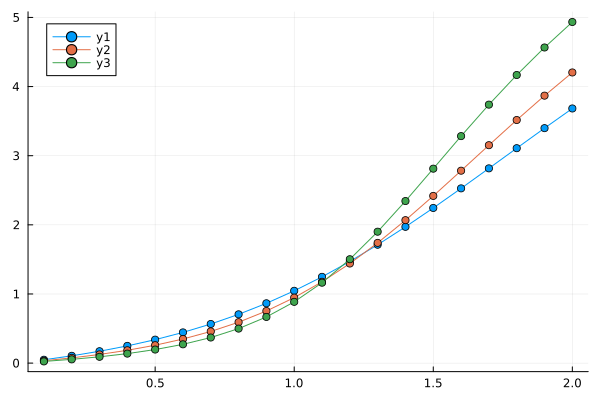

In [39]:

p11=plot(gg, ada_data[1]/sqrt(5), marker=:circle)
p11=plot!(gg, ada_data[2]/sqrt(10), marker=:circle)
p11=plot!(gg, ada_data[3]/sqrt(20), marker=:circle)

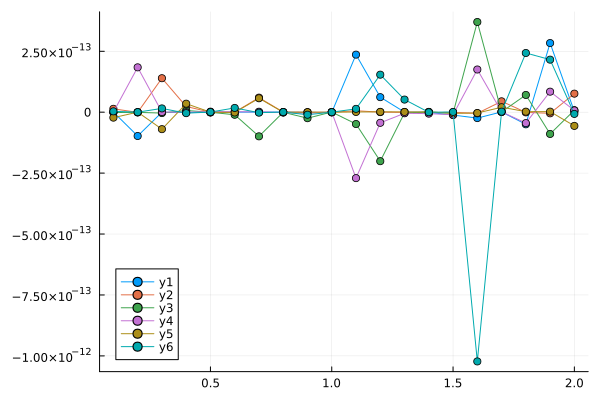

In [35]:
p22=plot(gg, real.(a_data[1]), marker=:circle)
p22=plot!(gg, real.(a_data[2]), marker=:circle)
p22=plot!(gg, real.(a_data[3]), marker=:circle)
p22=plot!(gg, imag.(a_data[1]), marker=:circle)
p22=plot!(gg, imag.(a_data[2]), marker=:circle)
p22=plot!(gg, imag.(a_data[3]), marker=:circle)

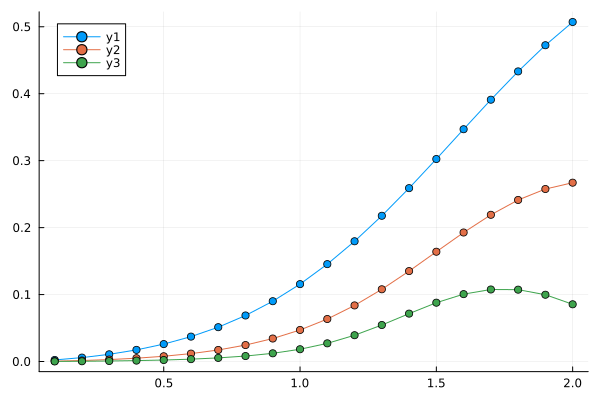

In [40]:
p33=plot(gg, -real.(aa_data[1])/5, marker=:circle)
p33=plot!(gg, -real.(aa_data[2])/10, marker=:circle)
p33=plot!(gg, -real.(aa_data[3])/20, marker=:circle)

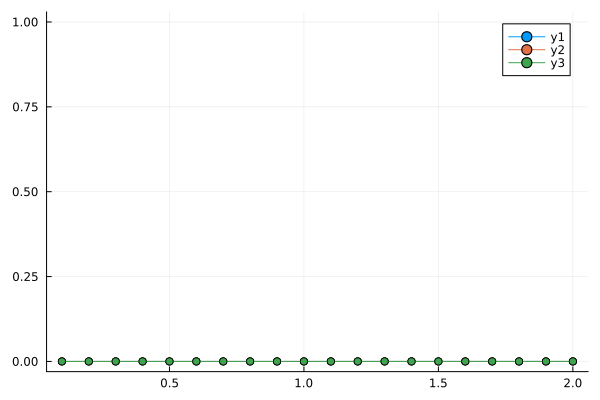

In [21]:
p33=plot(gg, imag.(aN_data[1]), marker=:circle)
p33=plot!(gg, imag.(aN_data[2]), marker=:circle)
p33=plot!(gg, imag.(aN_data[3]), marker=:circle)

In [67]:
A=[]
push!(A, 5)

1-element Vector{Any}:
 5

In [101]:
p30_100_LC = Parm(1.0, 0.5, 0.000001, 0.1, 30, 16.0)
L_n30_100 = make_GKSL(p30_100_LC)
check_conservation(L_n30_100)

0, 1; sum:0.0 + 0.0im
1, 33; sum:0.0 + 0.0im
2, 65; sum:0.0 + 0.0im
3, 97; sum:0.0 + 0.0im
4, 129; sum:0.0 + 0.0im
5, 161; sum:0.0 + 0.0im
6, 193; sum:0.0 + 0.0im
7, 225; sum:0.0 + 0.0im
8, 257; sum:0.0 + 0.0im
9, 289; sum:0.0 + 0.0im
10, 321; sum:0.0 + 0.0im
11, 353; sum:0.0 + 0.0im
12, 385; sum:0.0 + 0.0im
13, 417; sum:1.7763568394002505e-15 + 0.0im
14, 449; sum:0.0 + 0.0im
15, 481; sum:0.0 + 0.0im
16, 513; sum:0.0 + 0.0im
17, 545; sum:0.0 + 0.0im
18, 577; sum:0.0 + 0.0im
19, 609; sum:0.0 + 0.0im
20, 641; sum:0.0 + 0.0im
21, 673; sum:-3.552713678800501e-15 + 0.0im
22, 705; sum:0.0 + 0.0im
23, 737; sum:0.0 + 0.0im
24, 769; sum:0.0 + 0.0im
25, 801; sum:-3.552713678800501e-15 + 0.0im
26, 833; sum:3.552713678800501e-15 + 0.0im
27, 865; sum:0.0 + 0.0im
28, 897; sum:0.0 + 0.0im
29, 929; sum:0.0 + 0.0im
30, 961; sum:0.0 + 0.0im


In [102]:
E_log_LC, SS_vec_LC = get_Elog_vec(p30_100_LC, L_n30_100)

(ComplexF64[1.06692224814309 + 2.100000001069344im, 1.0669222481430727 - 2.100000001069349im, 1.0544583656453093 + 0.09999999744339151im, 1.0544583656449709 - 0.09999999744348054im, 1.031936617886529 - 0.8999999985882107im, 1.0319366178865235 + 0.8999999985881968im, 1.018964194803444 - 0.2999999986395292im, 1.0189641948033759 + 0.29999999864027804im, 1.0076396600380175 - 0.6999999990434121im, 1.007639660037982 + 0.6999999990432966im  …  -2.599997671490503 - 0.3999999974188321im, -3.193553814842868 - 0.2999999978271802im, -3.1935538148442135 + 0.29999999782718273im, -4.022432713894972 + 0.19999999855759115im, -4.022432713895468 - 0.19999999855758413im, -5.4264320687858305 + 0.09999993824623482im, -5.426432068791199 - 0.099999938246217im, -7.723076662323306 - 2.9999999999603055im, -7.72307666241283 + 2.999999999960224im, -30.167966882381425 + 1.3567641058584856e-14im], Any[ComplexF64[4.662718565592994e-10 + 1.9320947955742708e-15im -8.74631848496355e-19 - 8.910638572293919e-21im … 1.4994

In [103]:
p30_10_LC = Parm(1.0, 0.5, 0.0001, 0.1, 30, 16.0)
L_n30_10 = make_GKSL(p30_10_LC)
check_conservation(L_n30_10)

0, 1; sum:0.0 + 0.0im
1, 33; sum:0.0 + 0.0im
2, 65; sum:0.0 + 0.0im
3, 97; sum:0.0 + 0.0im
4, 129; sum:0.0 + 0.0im
5, 161; sum:0.0 + 0.0im
6, 193; sum:0.0 + 0.0im
7, 225; sum:0.0 + 0.0im
8, 257; sum:0.0 + 0.0im
9, 289; sum:0.0 + 0.0im
10, 321; sum:0.0 + 0.0im
11, 353; sum:-1.7763568394002505e-15 + 0.0im
12, 385; sum:0.0 + 0.0im
13, 417; sum:0.0 + 0.0im
14, 449; sum:0.0 + 0.0im
15, 481; sum:0.0 + 0.0im
16, 513; sum:0.0 + 0.0im
17, 545; sum:0.0 + 0.0im
18, 577; sum:0.0 + 0.0im
19, 609; sum:0.0 + 0.0im
20, 641; sum:0.0 + 0.0im
21, 673; sum:0.0 + 0.0im
22, 705; sum:0.0 + 0.0im
23, 737; sum:0.0 + 0.0im
24, 769; sum:0.0 + 0.0im
25, 801; sum:0.0 + 0.0im
26, 833; sum:0.0 + 0.0im
27, 865; sum:0.0 + 0.0im
28, 897; sum:3.552713678800501e-15 + 0.0im
29, 929; sum:0.0 + 0.0im
30, 961; sum:0.0 + 0.0im


In [104]:
E_log_LC2, SS_vec_LC2 = get_Elog_vec(p30_10_LC, L_n30_10)

(ComplexF64[1.075775968324674 - 2.1000104855963615im, 1.075775968324663 + 2.100010485596326im, 1.0521920957338495 - 0.09997466628245961im, 1.0521920957336304 + 0.09997466628234644im, 1.0305159859536381 + 0.8999859618689374im, 1.030515985953634 - 0.899985961868948im, 1.0167104585649673 + 0.2999867977140155im, 1.0167104585649196 - 0.29998679771372im, 1.006542872026673 + 0.6999908227989394im, 1.0065428720266212 - 0.6999908227987942im  …  -2.58555348831679 - 0.39997450569224563im, -3.1185572870155935 - 2.999999602156547im, -3.118557287017114 + 2.999999602156509im, -3.178406603497663 + 0.2999784548927813im, -3.1784066034978418 - 0.29997845489279595im, -4.005759262432858 + 0.19998568974931552im, -4.005759262433922 - 0.19998568974934897im, -5.408358160811339 + 0.09938742317221988im, -5.408358160811874 - 0.09938742317217591im, -29.526224340598837 + 5.05125914200349e-16im], Any[ComplexF64[5.30198373231063e-10 - 4.232931737620031e-16im 6.402360812539976e-17 + 2.4237729465194564e-18im … -2.027773

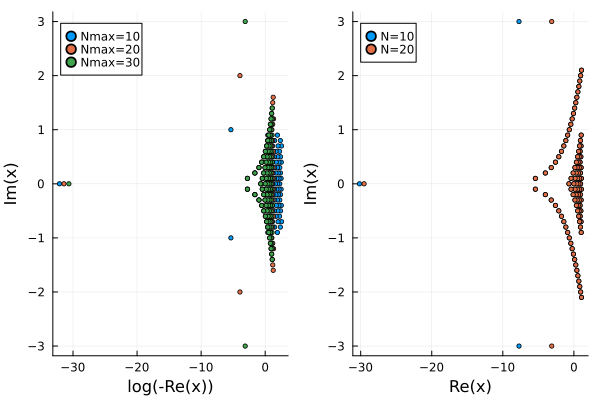

In [106]:
plc=plot(E_log_LC, st=:scatter, ms=2.4, xlabel="log(-Re(x))", label="N=10")
plc=plot!(E_log_LC2, st=:scatter, ms=2.4, label="N=20")
plot(pn, plc, layout=(1,2))
#plot!(E_log, st=:scatter, ps=0.5, xlabel="log(-Re(x))", label="U/N=1e-4")
#plot!(E_log2, st=:scatter, ps=0.5, xlabel="log(-Re(x))", label="U/N=1e-3")

In [32]:
size(SS_vec_LC2)

(3,)

In [48]:
s1 =plot(real.(SS_vec2[1]), st=:heatmap, c=:vanimo, clims=(-0.05,0.05))
savefig(s1, "SS_QvdP.png")
#s2 =plot(real.(SS_vec_LC2[1]), st=:heatmap, c=:vanimo, clims=(-0.2,0.2))
#plot(s1, s2, layout=(1,2))

"/home/yoshihiro/Documents/Codes/julia/DTC-LC/SS_QvdP.png"

In [47]:
#p1=plot(real.(SS_vec[2]), st=:heatmap, c=:vanimo, clims=(-0.2,0.2))
#p1=plot(real.(SS_vec2[2]), st=:heatmap, c=:vanimo, clims=(-0.2,0.2))
#p2=plot(real.(SS_vec2[3]), st=:heatmap, c=:vanimo, clims=(-0.2,0.2))
#p3=plot(real.(SS_vec_LC[2]), st=:heatmap, c=:vanimo, clims=(-0.2,0.2))
p1=plot(real.(SS_vec2[2]), st=:heatmap, c=:vanimo, clims=(-0.05,0.05))
p3=plot(real.(SS_vec2[3]), st=:heatmap, c=:vanimo, clims=(-0.05,0.05))
p2=plot(imag.(SS_vec2[2]), st=:heatmap, c=:vanimo, clims=(-0.01,0.01))
p4=plot(imag.(SS_vec2[3]), st=:heatmap, c=:vanimo, clims=(-0.01,0.01))
px = plot(p1, p2, p3, p4, layout=(2,2))
savefig(px, "Nmax60_N20_SS+im.png")
#plot(p3, p4, layout=(1,2))

"/home/yoshihiro/Documents/Codes/julia/DTC-LC/Nmax60_N20_SS+im.png"

In [11]:
function init_vec(p::Parm)
    vec = zeros(ComplexF64, (p.Nmax+1)^2)
    for i in 1:p.Nmax+1
        vec[(i-1)*(p.Nmax+1)+i] = 1.0/(p.Nmax+1)
    end
    return vec
end

init_vec (generic function with 1 method)

In [28]:
function init_vec2(p::Parm)
    vec = zeros(ComplexF64, (p.Nmax+1)^2)
    for i in 1:p.Nmax+1
        vec[(i-1)*(p.Nmax+1)+i] = 1.0/(p.Nmax+1)
    end
    vec[(p.Nmax+1)+1] = 0.5
    vec[2] = 0.5
    vec[2*(p.Nmax+1)+1] = 0.5
    vec[3] = 0.5
    return vec
end

init_vec2 (generic function with 1 method)

In [13]:
function calc_expectation_val2(rho)
    ada = 0.0
    adad = 0.0
    a = 0.0
    aa = 0.0
    dd=0.0
    for i in 1:size(rho)[1]-1
        ada += real((i)*rho[i+1,i+1])
        adad += real((i)^2*rho[i+1,i+1])
        a += sqrt(i)*rho[i+1,i]
        if(i<size(rho)[1]-1)
            aa += sqrt(i*(i+1))*rho[i+2,i]
            dd += sqrt(i*(i+1))*rho[i,i+2]
        end
    end
    return ada,adad, a, aa, dd
end

calc_expectation_val2 (generic function with 1 method)

In [29]:
function calc_dynamics(p::Parm,tmax, t_step, GKSL)
    dt = tmax/t_step
    U = exp(GKSL.*dt)
    #vec = init_vec(p)
    vec = init_vec2(p)
    data = zeros(ComplexF64, t_step, 4)
    for t in 1:t_step
        vec = U*vec
        #ada, a, aa = calc_expectation_val(reshape(vec,(p.Nmax+1,p.Nmax+1)))
        ada, a, aa, aN = calc_expectation_val_aN(reshape(vec,(p.Nmax+1,p.Nmax+1)), p.Nmax)
        data[t,:] = [ada, a, aa, aN]
    end
    return data
end

calc_dynamics (generic function with 1 method)

In [30]:
p20_100 = Parm(1.5, 1.0, 0.01, 0.0, 1.0, 60)
L = make_GKSL2(p20_100)

3721×3721 Matrix{ComplexF64}:
 -1.5+0.0im    0.0+0.0im    0.0+0.0im  …      0.0+0.0im    0.0+0.0im
  0.0+0.0im  -2.75+1.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im  -4.01+2.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im  …      0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
     ⋮                                 ⋱                      ⋮
  0.0+0.0im    0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im         0.0+0.0im    0.0+0.0im
  0.0+0.0

In [31]:
dyn = calc_dynamics(p20_100, 40.0, 1000, L)

1000×4 Matrix{ComplexF64}:
 29.6784+0.0im   0.504609+0.0201951im    0.718744+0.0576225im  0.0+0.0im
 29.3912+0.0im    0.50842+0.0407606im    0.725771+0.117125im   0.0+0.0im
 29.1284+0.0im   0.511409+0.0616654im    0.727956+0.178143im   0.0+0.0im
 28.8856+0.0im   0.513556+0.0828774im    0.725094+0.240289im   0.0+0.0im
 28.6598+0.0im   0.514839+0.104363im     0.717014+0.303149im   0.0+0.0im
 28.4489+0.0im   0.515238+0.126087im     0.703576+0.366289im   0.0+0.0im
 28.2514+0.0im   0.514736+0.148015im     0.684675+0.429257im   0.0+0.0im
 28.0659+0.0im   0.513317+0.170108im     0.660247+0.491583im   0.0+0.0im
 27.8915+0.0im   0.510964+0.192328im     0.630267+0.552787im   0.0+0.0im
 27.7272+0.0im   0.507665+0.214637im      0.59475+0.612377im   0.0+0.0im
        ⋮                                                      
 25.5209+0.0im  -0.224258+0.515843im    -0.112717-0.120844im   0.0+0.0im
 25.5209+0.0im  -0.244489+0.506011im    -0.102376-0.129058im   0.0+0.0im
 25.5209+0.0im  -0.264293+0.49538

In [16]:
using Plots

In [33]:
p1 = plot(real.(dyn[:,1]),yaxis=:log, label="ada")
p2=plot(real.(dyn[:,2]), label="a")
p2=plot!(real.(dyn[:,3]), label="aa")
#p2=plot!(real.(dyn[:,4])/1e62, label="aN*e-60")
pt = plot(p1, p2, layout=(1,2))
#savefig(pt, "dynamics_QvdP_normal_0610.png")
savefig(pt, "dynamics_LandauStuart_LC_log_0614.png")

"/home/yoshihiro/Documents/Codes/julia/DTC-LC/dynamics_LandauStuart_LC_log_0614.png"